<a href="https://colab.research.google.com/github/khykelly-cloud/mul/blob/main/%EB%AC%BC%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

customer = pd.read_csv("Customer.csv")
dc = pd.read_csv("DistributionCenter.csv")
truck = pd.read_csv("Truck.csv")

print(customer.head())
print(dc.head())
print(truck.head())


    X   Y  DEMAND
0  37  52       7
1   9  49      30
2   2  64      16
3   0  26       9
4   0  30      21
    X   Y  CAPACITY  COST
0  30  46     10000    40
1  37  39     10000    40
2  23  43     10000    40
3  56  38     10000    40
4  42  43     10000    40
   CAPACITY
0       160


In [2]:
import numpy as np
from scipy.spatial.distance import cdist

# 고객 → 센터 거리 행렬 (50 × 5)
distance_dc_customer = cdist(
    customer[['X','Y']],
    dc[['X','Y']],
    metric='euclidean'
)

distance_dc_customer[:5]   # 앞부분만 출력


array([[ 9.21954446, 13.        , 16.64331698, 23.60084744, 10.29563014],
       [21.21320344, 29.73213749, 15.23154621, 48.27007354, 33.54101966],
       [33.28663395, 43.01162634, 29.69848481, 59.93329626, 45.17742799],
       [36.05551275, 39.2173431 , 28.60069929, 57.27128425, 45.31004304],
       [34.        , 38.07886553, 26.41968963, 56.56854249, 43.96589587]])

In [3]:
customer = pd.read_csv("Customer.csv")
dc = pd.read_csv("DistributionCenter.csv")
truck = pd.read_csv("Truck.csv")

I = range(len(dc))          # 5개 물류센터 후보지
J = range(len(customer))    # 50명 고객


In [4]:
distance_dc_customer = cdist(
    customer[['X','Y']],
    dc[['X','Y']],
    metric='euclidean'
)


In [14]:
import pulp


In [13]:
!pip install ortools


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 19.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.31.1 which is incompatible.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.

Status: Optimal
열린 DC: [0, 1, 2, 3, 4]

DC별 고객 배정 결과
DC 0: 고객 [0, 25, 26, 30, 47]
DC 1: 고객 [11, 14, 16, 36, 43, 44, 45]
DC 2: 고객 [1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 17, 18, 22, 23, 24, 39, 40, 41, 42, 46]
DC 3: 고객 [9, 15, 19, 20, 28, 29, 32, 33, 34, 35, 38, 48, 49]
DC 4: 고객 [10, 21, 27, 31, 37]


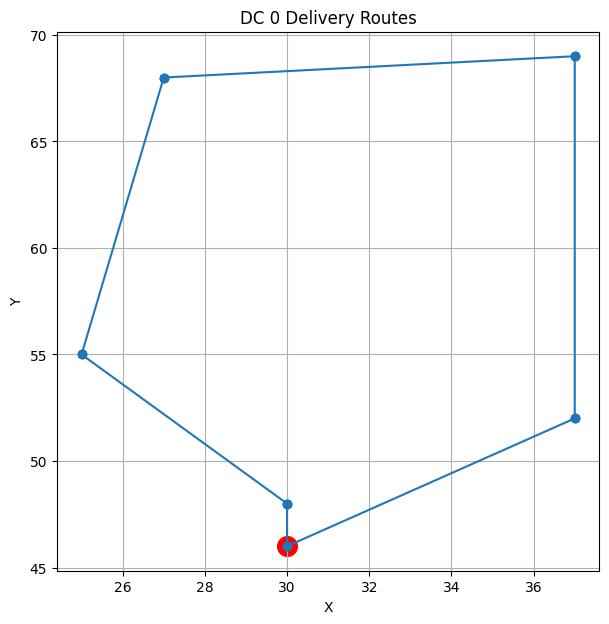

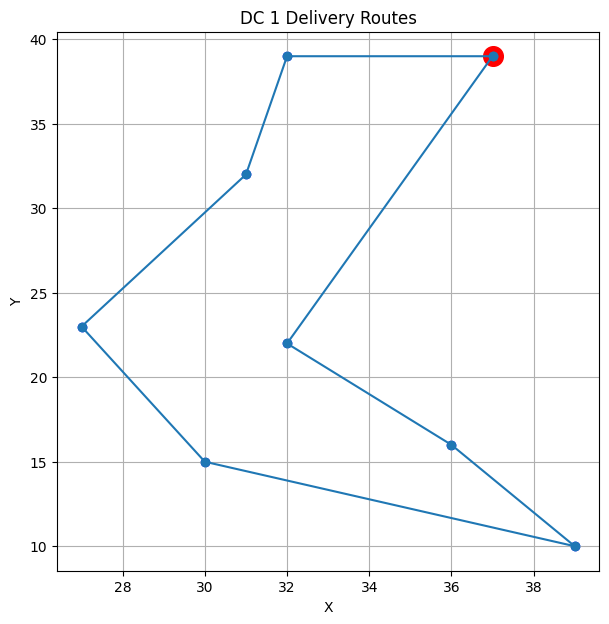

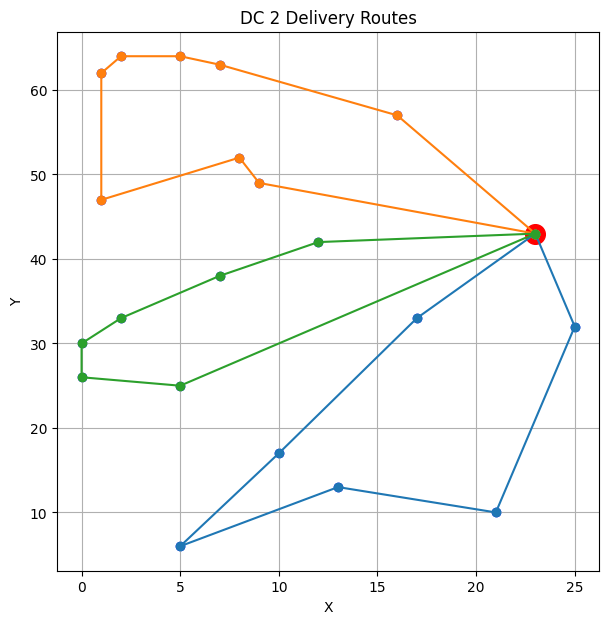

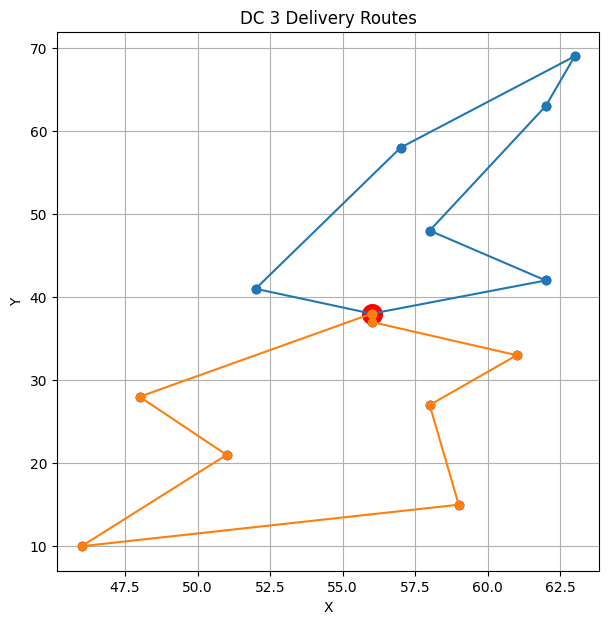

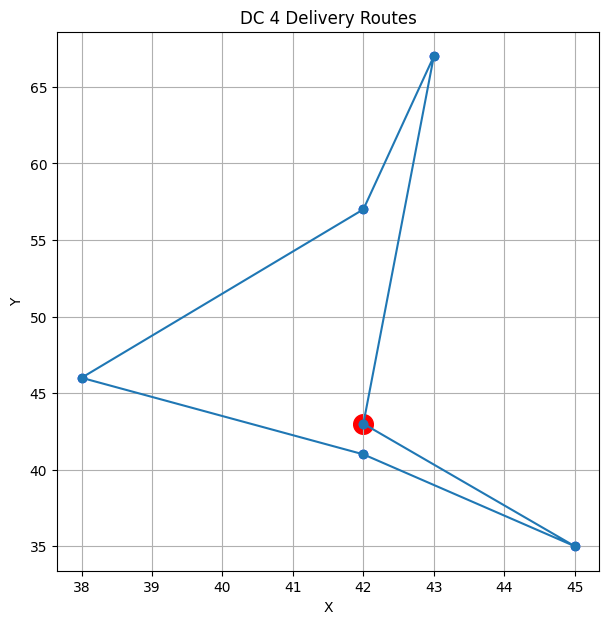

In [15]:
# =========================================================
# 0. 라이브러리 로드
# =========================================================
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import pulp


# =========================================================
# 1. CSV 불러오기
# =========================================================
customer = pd.read_csv("Customer.csv")
dc = pd.read_csv("DistributionCenter.csv")
truck = pd.read_csv("Truck.csv")

I = range(len(dc))          # DC index
J = range(len(customer))    # Customer index


# =========================================================
# 2. 거리행렬 생성 (고객 → DC)
# =========================================================
distance_dc_customer = cdist(
    customer[['X','Y']],
    dc[['X','Y']],
    metric='euclidean'
)


# =========================================================
# 3. Facility Location Problem (입지선정 MIP)
# =========================================================
model = pulp.LpProblem("FacilityLocation", pulp.LpMinimize)

# 결정변수
y = pulp.LpVariable.dicts("open_dc", I, cat='Binary')
x = pulp.LpVariable.dicts("assign", (I, J), cat='Binary')

# 목적함수 (센터개설비 + 수송비)
facility_cost = pulp.lpSum(dc.loc[i,'COST'] * y[i] for i in I)

transport_cost = pulp.lpSum(
    distance_dc_customer[j,i] * customer.loc[j,'DEMAND'] * x[i][j]
    for i in I for j in J
)

model += facility_cost + transport_cost

# 제약 1: 고객은 하나의 DC에만 할당
for j in J:
    model += pulp.lpSum(x[i][j] for i in I) == 1

# 제약 2: DC 용량 제한
for i in I:
    model += pulp.lpSum(customer.loc[j,'DEMAND'] * x[i][j] for j in J) <= dc.loc[i,'CAPACITY']

# 제약 3: DC 안 열면 배정 불가
for i in I:
    for j in J:
        model += x[i][j] <= y[i]

# 최적화 실행
model.solve(pulp.PULP_CBC_CMD(msg=False))
print("Status:", pulp.LpStatus[model.status])


# =========================================================
# 4. FLP 결과: 개설된 DC + 고객 배정
# =========================================================
open_dcs = [i for i in I if y[i].value() == 1]
print("열린 DC:", open_dcs)

# DC별 고객 리스트
dc_customers = {i: [] for i in open_dcs}

for i in open_dcs:
    for j in J:
        if x[i][j].value() == 1:
            dc_customers[i].append(j)

print("\nDC별 고객 배정 결과")
for i in dc_customers:
    print(f"DC {i}: 고객 {dc_customers[i]}")


# =========================================================
# 5. VRP Solver (OR-Tools)
# =========================================================
def solve_vrp(coords, demands, truck_capacity):
    distance_matrix = cdist(coords, coords, 'euclidean').astype(int)

    num_locations = len(coords)
    num_vehicles = 10    # 충분히 크게
    depot = 0

    manager = pywrapcp.RoutingIndexManager(num_locations, num_vehicles, depot)
    routing = pywrapcp.RoutingModel(manager)

    # 거리 콜백
    def distance_callback(i, j):
        return distance_matrix[manager.IndexToNode(i)][manager.IndexToNode(j)]
    transit_callback = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback)

    # 수요 콜백
    def demand_callback(i):
        return demands[manager.IndexToNode(i)]
    demand_idx = routing.RegisterUnaryTransitCallback(demand_callback)

    routing.AddDimensionWithVehicleCapacity(
        demand_idx,
        0,
        [truck_capacity]*num_vehicles,
        True,
        "Capacity"
    )

    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    solution = routing.SolveWithParameters(search_params)
    routes = []

    if solution:
        for v in range(num_vehicles):
            idx = routing.Start(v)
            if routing.IsEnd(solution.Value(routing.NextVar(idx))):
                continue

            route = []
            while not routing.IsEnd(idx):
                route.append(manager.IndexToNode(idx))
                idx = solution.Value(routing.NextVar(idx))
            route.append(manager.IndexToNode(idx))  # depot 반환
            routes.append(route)

    return routes


# =========================================================
# 6. 각 DC에 대해 VRP 실행
# =========================================================
vrp_routes = {}

for i in open_dcs:
    assigned = dc_customers[i]

    coords = [(dc.loc[i,'X'], dc.loc[i,'Y'])] + [
        (customer.loc[j,'X'], customer.loc[j,'Y']) for j in assigned
    ]
    demands = [0] + [customer.loc[j,'DEMAND'] for j in assigned]

    vrp_routes[i] = solve_vrp(coords, demands, truck.loc[0,'CAPACITY'])


# =========================================================
# 7. 시각화
# =========================================================
for i in open_dcs:
    plt.figure(figsize=(7,7))
    assigned = dc_customers[i]

    # DC
    plt.scatter(dc.loc[i,'X'], dc.loc[i,'Y'], c='red', s=200, label=f"DC {i}")

    # 고객들
    plt.scatter(customer.loc[assigned,'X'], customer.loc[assigned,'Y'], c='blue')

    # 경로
    coords = [(dc.loc[i,'X'], dc.loc[i,'Y'])] + [
        (customer.loc[j,'X'], customer.loc[j,'Y']) for j in assigned
    ]

    for route in vrp_routes[i]:
        xs = [coords[k][0] for k in route]
        ys = [coords[k][1] for k in route]
        plt.plot(xs, ys, '-o')

    plt.title(f"DC {i} Delivery Routes")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid()
    plt.show()


In [16]:
vrp_routes


{0: [[0, 1, 4, 2, 5, 3, 0]],
 1: [[0, 7, 1, 3, 5, 6, 2, 4, 0]],
 2: [[0, 11, 17, 16, 12, 18, 20, 0],
  [0, 1, 14, 5, 7, 2, 19, 6, 13, 0],
  [0, 10, 15, 8, 4, 3, 9, 0]],
 3: [[0, 2, 3, 10, 9, 5, 4, 0], [0, 13, 8, 6, 11, 7, 1, 12, 0]],
 4: [[0, 5, 1, 4, 2, 3, 0]]}

In [18]:
def compute_route_distance(route, coords):
    """주어진 경로(route)와 좌표(coords)를 이용해 총 이동거리 계산"""
    dist = 0
    for i in range(len(route) - 1):
        x1, y1 = coords[route[i]]
        x2, y2 = coords[route[i+1]]
        dist += np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    return dist


In [19]:
dc_costs = {}      # DC별 전체 비용 저장
total_network_cost = 0

for i in open_dcs:
    print(f"\n===============================")
    print(f"📦 DC {i} 비용 계산 시작")
    print(f"===============================")

    # 해당 DC 개설 비용
    fixed_cost = dc.loc[i, 'COST']
    print(f"DC 개설비용: {fixed_cost}")

    # 고객 좌표 & 수요
    assigned = dc_customers[i]
    coords = [(dc.loc[i,'X'], dc.loc[i,'Y'])] + [
        (customer.loc[j,'X'], customer.loc[j,'Y']) for j in assigned
    ]
    demands = [0] + [customer.loc[j,'DEMAND'] for j in assigned]

    # VRP 경로
    routes = vrp_routes[i]

    dc_delivery_cost = 0
    truck_id = 1

    for route in routes:
        if len(route) <= 2:
            continue   # depot만 왔다갔다하는 빈 경로 무시

        # 이동거리 계산
        distance = compute_route_distance(route, coords)

        # 배송비 = 거리 × 수요량 합
        # 단, VRP는 순회이므로 '수요량에 거리 곱'이 아니라 '경로 이동거리 자체'를 비용으로 본다.
        delivery_cost = distance

        print(f"트럭 {truck_id} 경로: {route}")
        print(f"   이동거리 = {distance:.2f}")
        print(f"   배송비   = {delivery_cost:.2f}")

        dc_delivery_cost += delivery_cost
        truck_id += 1

    # DC 총 비용 = 개설비 + 배송비
    dc_total_cost = fixed_cost + dc_delivery_cost
    dc_costs[i] = dc_total_cost
    total_network_cost += dc_total_cost

    print(f"👉 DC {i} 총 배송비 = {dc_delivery_cost:.2f}")
    print(f"👉 DC {i} 총 비용(개설비 포함) = {dc_total_cost:.2f}")



📦 DC 0 비용 계산 시작
DC 개설비용: 40
트럭 1 경로: [0, 1, 4, 2, 5, 3, 0]
   이동거리 = 60.02
   배송비   = 60.02
👉 DC 0 총 배송비 = 60.02
👉 DC 0 총 비용(개설비 포함) = 100.02

📦 DC 1 비용 계산 시작
DC 개설비용: 40
트럭 1 경로: [0, 7, 1, 3, 5, 6, 2, 4, 0]
   이동거리 = 72.40
   배송비   = 72.40
👉 DC 1 총 배송비 = 72.40
👉 DC 1 총 비용(개설비 포함) = 112.40

📦 DC 2 비용 계산 시작
DC 개설비용: 40
트럭 1 경로: [0, 11, 17, 16, 12, 18, 20, 0]
   이동거리 = 93.92
   배송비   = 93.92
트럭 2 경로: [0, 1, 14, 5, 7, 2, 19, 6, 13, 0]
   이동거리 = 75.94
   배송비   = 75.94
트럭 3 경로: [0, 10, 15, 8, 4, 3, 9, 0]
   이동거리 = 62.68
   배송비   = 62.68
👉 DC 2 총 배송비 = 232.54
👉 DC 2 총 비용(개설비 포함) = 272.54

📦 DC 3 비용 계산 시작
DC 개설비용: 40
트럭 1 경로: [0, 2, 3, 10, 9, 5, 4, 0]
   이동거리 = 71.28
   배송비   = 71.28
트럭 2 경로: [0, 13, 8, 6, 11, 7, 1, 12, 0]
   이동거리 = 72.59
   배송비   = 72.59
👉 DC 3 총 배송비 = 143.87
👉 DC 3 총 비용(개설비 포함) = 183.87

📦 DC 4 비용 계산 시작
DC 개설비용: 40
트럭 1 경로: [0, 5, 1, 4, 2, 3, 0]
   이동거리 = 67.43
   배송비   = 67.43
👉 DC 4 총 배송비 = 67.43
👉 DC 4 총 비용(개설비 포함) = 107.43


In [20]:
print("\n===============================")
print("🚚 전체 네트워크 총 비용")
print("===============================")

for i in dc_costs:
    print(f"DC {i}: {dc_costs[i]:.2f}")

print(f"\n📌 전체 최종 비용 = {total_network_cost:.2f}")



🚚 전체 네트워크 총 비용
DC 0: 100.02
DC 1: 112.40
DC 2: 272.54
DC 3: 183.87
DC 4: 107.43

📌 전체 최종 비용 = 776.26


        Clarke–Wright VRP 결과

🚚 DC 0 처리 시작
  트럭 1: 경로 = [0, 3, 0] | 거리 = 4.00
  트럭 2: 경로 = [0, 1, 2, 4, 5, 0] | 거리 = 66.87
👉 DC 0 배송비 = 70.87
👉 DC 0 총 비용(개설비 포함) = 110.87

🚚 DC 1 처리 시작
  트럭 1: 경로 = [0, 2, 6, 0] | 거리 = 58.80
  트럭 2: 경로 = [0, 1, 3, 4, 5, 7, 0] | 거리 = 60.53
👉 DC 1 배송비 = 119.33
👉 DC 1 총 비용(개설비 포함) = 159.33

🚚 DC 2 처리 시작
  트럭 1: 경로 = [0, 2, 7, 19, 0] | 거리 = 64.07
  트럭 2: 경로 = [0, 1, 5, 6, 14, 0] | 거리 = 69.10
  트럭 3: 경로 = [0, 3, 4, 8, 9, 12, 16, 17, 18, 20, 0] | 거리 = 128.47
  트럭 4: 경로 = [0, 10, 15, 0] | 거리 = 34.21
  트럭 5: 경로 = [0, 11, 13, 0] | 거리 = 51.34
👉 DC 2 배송비 = 347.18
👉 DC 2 총 비용(개설비 포함) = 387.18

🚚 DC 3 처리 시작
  트럭 1: 경로 = [0, 2, 3, 9, 10, 0] | 거리 = 67.65
  트럭 2: 경로 = [0, 1, 7, 11, 12, 13, 0] | 거리 = 73.80
  트럭 3: 경로 = [0, 4, 5, 6, 8, 0] | 거리 = 49.20
👉 DC 3 배송비 = 190.66
👉 DC 3 총 비용(개설비 포함) = 230.66

🚚 DC 4 처리 시작
  트럭 1: 경로 = [0, 2, 3, 4, 0] | 거리 = 50.64
  트럭 2: 경로 = [0, 1, 5, 0] | 거리 = 17.25
👉 DC 4 배송비 = 67.89
👉 DC 4 총 비용(개설비 포함) = 107.89

🔥 Clarke–Wright 전체 네트워크 총 비용
D

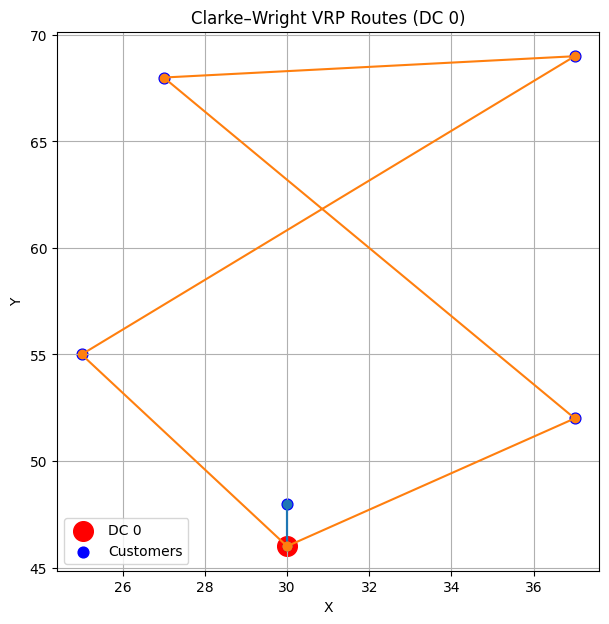

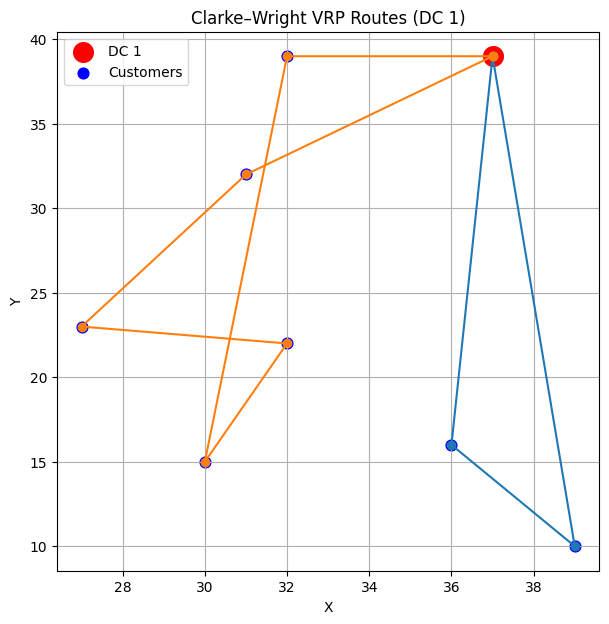

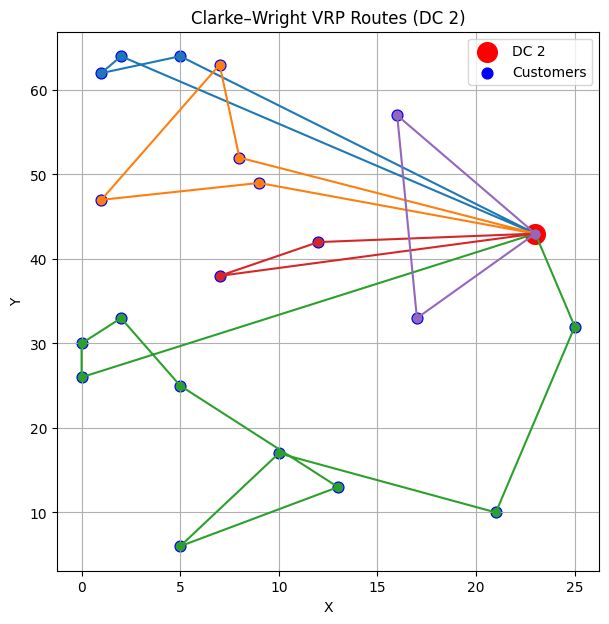

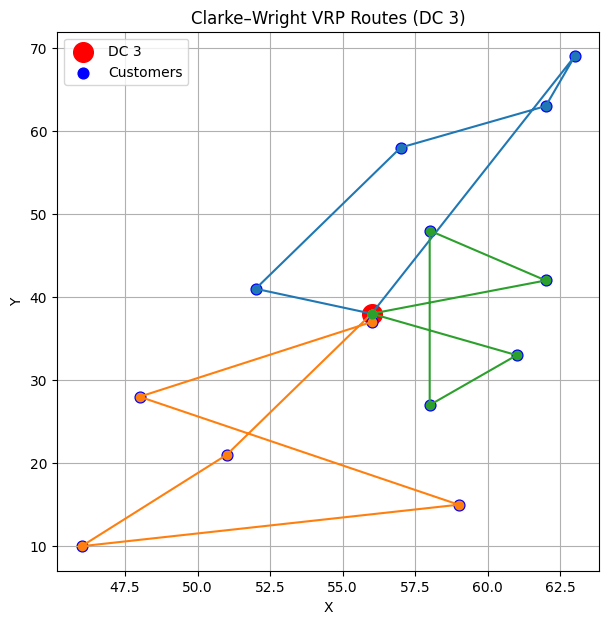

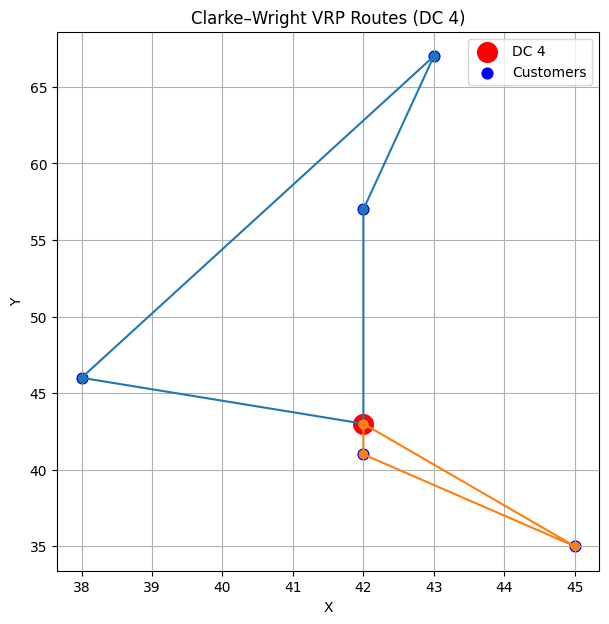

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# =========================================================
# 1. Clarke–Wright Savings Algorithm
# =========================================================
def clarke_wright(coords, demands, cap):
    n = len(coords)
    dist = cdist(coords, coords, 'euclidean')

    # 초기 경로: 0→i→0
    routes = [[0, i, 0] for i in range(1, n)]

    # Savings 계산
    savings = []
    for i in range(1, n):
        for j in range(i+1, n):
            s = dist[0, i] + dist[0, j] - dist[i, j]
            savings.append((s, i, j))
    savings.sort(reverse=True, key=lambda x: x[0])

    # 병합 시작
    for s, i, j in savings:
        route_i = None
        route_j = None

        for r in routes:
            if r[-2] == i:
                route_i = r
            if r[1] == j:
                route_j = r

        if route_i and route_j and route_i != route_j:
            load_i = sum(demands[k] for k in route_i if k != 0)
            load_j = sum(demands[k] for k in route_j if k != 0)

            if load_i + load_j <= cap:
                new_route = route_i[:-1] + route_j[1:]
                routes.remove(route_i)
                routes.remove(route_j)
                routes.append(new_route)

    return routes


# =========================================================
# 2. 경로 거리 계산
# =========================================================
def route_distance(route, coords):
    d = 0
    for i in range(len(route)-1):
        x1, y1 = coords[route[i]]
        x2, y2 = coords[route[i+1]]
        d += np.sqrt((x1-x2)**2 + (y1-y2)**2)
    return d


# =========================================================
# 3. Clarke–Wright VRP 실행 + 비용 계산
# =========================================================
cw_routes = {}
cw_costs = {}
total_cw_cost = 0

print("====================================")
print("        Clarke–Wright VRP 결과")
print("====================================")

for dc_id in open_dcs:
    assigned = dc_customers[dc_id]

    # DC + 고객 좌표 구성
    coords = [(dc.loc[dc_id,'X'], dc.loc[dc_id,'Y'])] + \
             [(customer.loc[j,'X'], customer.loc[j,'Y']) for j in assigned]

    demands = [0] + [customer.loc[j,'DEMAND'] for j in assigned]
    cap = truck.loc[0,'CAPACITY']

    print(f"\n🚚 DC {dc_id} 처리 시작")

    # VRP 수행
    routes = clarke_wright(coords, demands, cap)
    cw_routes[dc_id] = routes

    # 비용 계산
    delivery_cost = 0
    for r_id, r in enumerate(routes, 1):
        dist = route_distance(r, coords)
        delivery_cost += dist
        print(f"  트럭 {r_id}: 경로 = {r} | 거리 = {dist:.2f}")

    fixed_cost = dc.loc[dc_id,'COST']
    total_cost = fixed_cost + delivery_cost

    cw_costs[dc_id] = total_cost
    total_cw_cost += total_cost

    print(f"👉 DC {dc_id} 배송비 = {delivery_cost:.2f}")
    print(f"👉 DC {dc_id} 총 비용(개설비 포함) = {total_cost:.2f}")


# =========================================================
# 4. 전체 네트워크 총 비용 출력
# =========================================================
print("\n====================================")
print("🔥 Clarke–Wright 전체 네트워크 총 비용")
print("====================================")

for dc_id in cw_costs:
    print(f"DC {dc_id}: 총 비용 = {cw_costs[dc_id]:.2f}")

print(f"\n🎯 최종 총 비용 = {total_cw_cost:.2f}")


# =========================================================
# 5. VRP 시각화
# =========================================================
for dc_id in cw_routes:
    plt.figure(figsize=(7,7))

    assigned = dc_customers[dc_id]

    # 좌표 구성
    coords = [(dc.loc[dc_id,'X'], dc.loc[dc_id,'Y'])] + \
             [(customer.loc[j,'X'], customer.loc[j,'Y']) for j in assigned]

    # DC 점
    plt.scatter(dc.loc[dc_id,'X'], dc.loc[dc_id,'Y'], c='red', s=200, label=f"DC {dc_id}")

    # 고객 점
    plt.scatter(customer.loc[assigned,'X'], customer.loc[assigned,'Y'],
                c='blue', s=60, label="Customers")

    # 경로
    for route in cw_routes[dc_id]:
        xs = [coords[k][0] for k in route]
        ys = [coords[k][1] for k in route]
        plt.plot(xs, ys, '-o')

    plt.title(f"Clarke–Wright VRP Routes (DC {dc_id})")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid()
    plt.legend()
    plt.show()
